### SVHN Preprocessing
This notebook implements SVHN pre-processing. The key steps are:

1. Read in some sample images and play with them.
2. Pull in full data (a) Extract labels and dimensions for each bounding box (height, width, left, top); (b) Resize and crop around the bounding box for each image; (c) Store in something more useful for python, such as a pickle file.

In [152]:
import scipy.ndimage as img
import scipy.misc as misc
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
import os
%matplotlib inline

In [153]:
train_struct_loc = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/digitStruct.mat'
img_loc1 = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/1.png'
img_loc2 = '/Users/pjmartin/Documents/Udacity/MachineLearningProgram/Project5/udacity-mle-project5/data/train/3.png'

# read in as B/W
img1 = img.imread(img_loc1,mode='L')
img2 = img.imread(img_loc2,mode='L')

(350, 741)


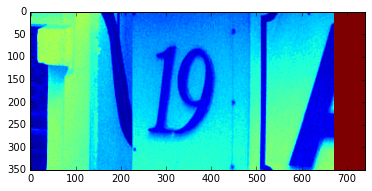

In [154]:
plt.imshow(img1)
print np.shape(img1)

(23, 52)


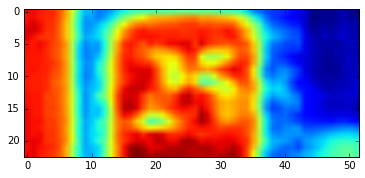

In [155]:
plt.imshow(img2)
print np.shape(img2)

(32, 32)


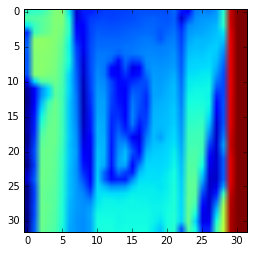

In [156]:
# Resizing demo...
img1_rs = misc.imresize(img1, (32,32))
plt.imshow(img1_rs)
print np.shape(img1_rs)

In [157]:
# Use the DigitStructFile class from github.com/hangyao
# The DigitStructFile is just a wrapper around the h5py data.  It basically references 
#    inf:              The input h5 matlab file
#    digitStructName   The h5 ref to all the file names
#    digitStructBbox   The h5 ref to all struc data
class DigitStructFile:
    def __init__(self, inf):
        self.inf = h5py.File(inf, 'r')
        self.digitStructName = self.inf['digitStruct']['name']
        self.digitStructBbox = self.inf['digitStruct']['bbox']

# getName returns the 'name' string for for the n(th) digitStruct. 
    def getName(self,n):
        return ''.join([chr(c[0]) for c in self.inf[self.digitStructName[n][0]].value])

# bboxHelper handles the coding difference when there is exactly one bbox or an array of bbox. 
    def bboxHelper(self,attr):
        if (len(attr) > 1):
            attr = [self.inf[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

# getBbox returns a dict of data for the n(th) bbox. 
    def getBbox(self,n):
        bbox = {}
        bb = self.digitStructBbox[n].item()
        bbox['height'] = self.bboxHelper(self.inf[bb]["height"])
        bbox['label'] = self.bboxHelper(self.inf[bb]["label"])
        bbox['left'] = self.bboxHelper(self.inf[bb]["left"])
        bbox['top'] = self.bboxHelper(self.inf[bb]["top"])
        bbox['width'] = self.bboxHelper(self.inf[bb]["width"])
        return bbox

    def getDigitStructure(self,n):
        s = self.getBbox(n)
        s['name']=self.getName(n)
        return s

# getAllDigitStructure returns all the digitStruct from the input file.     
    def getAllDigitStructure(self):
        return [self.getDigitStructure(i) for i in range(len(self.digitStructName))]

# Return a restructured version of the dataset (one structure by boxed digit).
#
#   Return a list of such dicts :
#      'filename' : filename of the samples
#      'boxes' : list of such dicts (one by digit) :
#          'label' : 1 to 9 corresponding digits. 10 for digit '0' in image.
#          'left', 'top' : position of bounding box
#          'width', 'height' : dimension of bounding box
#
# Note: We may turn this to a generator, if memory issues arise.
    def getAllDigitStructure_ByDigit(self):
        pictDat = self.getAllDigitStructure()
        result = []
        structCnt = 1
        for i in range(len(pictDat)):
            item = { 'filename' : pictDat[i]["name"] }
            figures = []
            for j in range(len(pictDat[i]['height'])):
               figure = {}
               figure['height'] = pictDat[i]['height'][j]
               figure['label']  = pictDat[i]['label'][j]
               figure['left']   = pictDat[i]['left'][j]
               figure['top']    = pictDat[i]['top'][j]
               figure['width']  = pictDat[i]['width'][j]
               figures.append(figure)
            structCnt = structCnt + 1
            item['boxes'] = figures
            result.append(item)
        return result

In [158]:
train_digitstruct = DigitStructFile(train_struct_loc)

In [159]:
train1_dict = train_digitstruct.getDigitStructure(0)
train2_dict = train_digitstruct.getDigitStructure(1)
print train1_dict
print train2_dict

{'name': '1.png', 'top': [77.0, 81.0], 'label': [1.0, 9.0], 'width': [81.0, 96.0], 'height': [219.0, 219.0], 'left': [246.0, 323.0]}
{'name': '2.png', 'top': [29.0, 25.0], 'label': [2.0, 3.0], 'width': [23.0, 26.0], 'height': [32.0, 32.0], 'left': [77.0, 98.0]}


In [160]:
# Now, lets mess with the 1 and 2 images to crop to the largest square around the bounding box.
min_top1 = int(np.min(train1_dict['top']))
min_left1 = int(np.min(train1_dict['left']))
total_height1 = int(np.max(train1_dict['height']))
total_width1 = int(np.sum(train1_dict['width']))
# Get maximum dimension to create the square around the numbers.
max_dim1 = int(np.max([total_height1, total_width1]) + np.floor(np.max([total_height1, total_width1])*0.2))

min_top2 = int(np.min(train2_dict['top']))
min_left2 = int(np.min(train2_dict['left']))
total_height2 = int(np.max(train2_dict['height']))
total_width2 = int(np.sum(train2_dict['width']))
# Get maximum dimension to create the square around the numbers.
max_dim2 = int(np.max([total_height2, total_width2]) + np.floor(np.max([total_height2, total_width2])*0.2))
print [total_height2, total_width2]

[32, 49]


In [161]:
img1_corner = np.array([np.floor(min_top1 - (min_top1 * 0.2)), np.floor(min_left1 - (min_left1 * 0.2)), ]).astype(int)
print img1_corner
img2_corner = np.array([np.floor(min_top2 - (min_top2 * 0.2)), np.floor(min_left2 - (min_left2 * 0.2)), ]).astype(int)
print img2_corner

[ 61 196]
[20 61]


In [162]:
img1_crop = img1[img1_corner[0]:img1_corner[0]+max_dim1,img1_corner[1]:img1_corner[1]+max_dim1]
img2_crop = img2[img2_corner[0]:img2_corner[0]+max_dim2,img2_corner[1]:img2_corner[1]+max_dim2]

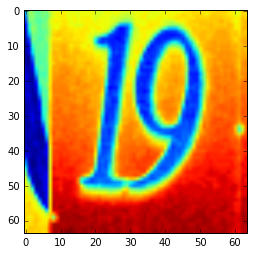

In [163]:
img1_rs = misc.imresize(img1_crop, (32,32))
plt.imshow(img1_rs)

In [164]:
img2_rs = misc.imresize(img2_crop, (32,32))
plt.imshow(img2_rs)

ValueError: tile cannot extend outside image